# Replication of the RKI model

The RKI published a [model](https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Modellierung_Deutschland.pdf) which features predictions over infections for three scenarios.

- A base scenario with a basic reproduction rate of 2.
- A scenario in which the reproduction rate fluctuates with the seasons.
- A scenario in which a third of the population is immune to the virus.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Base scenario

The base scenario assumes that we start with 1,000 infectious people among a population of 83,000,000. Among others, they parametrize their model with a $R_0 = 2$. $R_0$ is defined as

$$
    R_0 = \kappa * D * q
$$

where $\kappa$ is the number of contacts an infected has, $D$ is the average number of days people are infectious, and $q$ is the probability of infecting another person on contact.

Two of the parameters in this equation are exogenously determined. $D$ is equal to ten days and $R_0$ is either equal to 2 without pre-existing immunity in the population. If a third of the population is immune, $R_0$ is set to 3 to keep the effective reproduction rate the same in the beginning.

To summarize, their whole model depends on this relationship. We can set either the infection rate and get the correspondent number of contacts or vice versa.

Considering sid's current structure and anticipating seasonal fluctations in $R_0$, we set the infection rate as we have more ability to vary the number of contacts.

The following function computes the number of contacts dependent on all other parameters.

In [8]:
def infection_rate_to_number_of_contacts(
    infection_rate=0.05,
    r_0=2,
    n_days_infectious=10,
):
    return r_0 / n_days_infectious / infection_rate

If we set the infection rate to 5%, each individual has 4 contacts which we can set in sid's contact model.

In [9]:
infection_rate_to_number_of_contacts()

4.0

## Seasonality in the RKI model

Seasonality in the [RKI model](https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Modellierung_Deutschland.pdf) means that $R_0$ fluctuates from its peak at the end of the year to its bottom at the start of July. The RKI differentiates between

- weak seasonality with a peak at 2 and a low at 1.4
- and strong seasonality with a peak at 2 and a low at 0.67.

In sid, we can implement seasonality by keeping all parameters the same and varying the number of contacts in the contact model depending on the day of the year.

First, we need a function which receives the number of a day in the year and returns the correct $R_0$. The sine function is completely determined by its peak and bottom value.

In [23]:
def dayofyear_to_r_0(dayofyear, low, high):
    normalized_dayofyear = dayofyear / 365 * 2 * np.pi

    a = (high + low) / 2
    b = (high - low) / 2
    c = 0.5 * np.pi
    return a + b * np.sin(normalized_dayofyear + c)

In [24]:
s = pd.date_range(start="2020-03-08", end="2021-03-07")

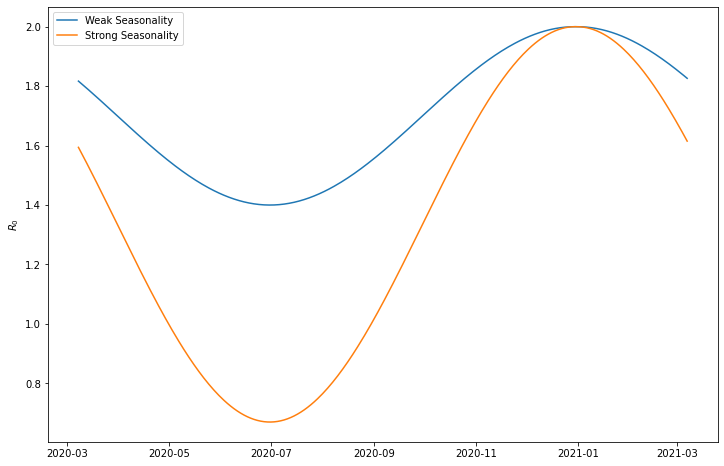

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(s, dayofyear_to_r_0(s.dayofyear, low=1.4, high=2), label="Weak Seasonality")
ax.plot(s, dayofyear_to_r_0(s.dayofyear, low=0.67, high=2), label="Strong Seasonality")
ax.set_ylabel("$R_0$")
ax.legend();

We already have the function which maps from $R_0$ to the number of contacts while keeping the infection rate at 5% and the duration of being infectious at 10 days.

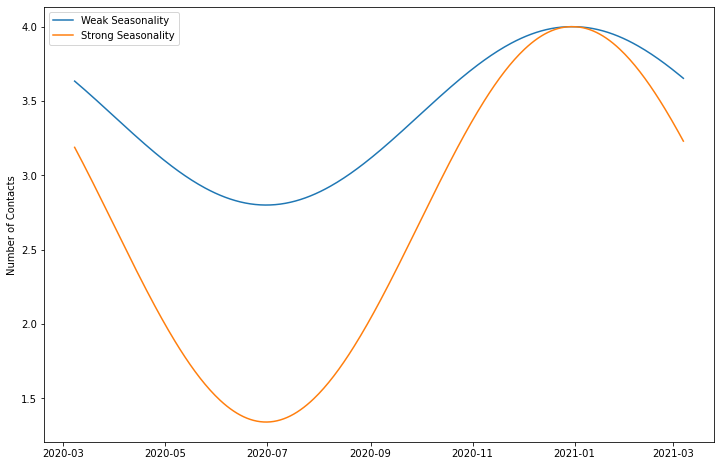

In [35]:
n_contacts_weak_seasonality = infection_rate_to_number_of_contacts(
    r_0=dayofyear_to_r_0(s.dayofyear, low=1.4, high=2)
)
n_contacts_strong_seasonality = infection_rate_to_number_of_contacts(
    r_0=dayofyear_to_r_0(s.dayofyear, low=0.67, high=2)
)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(s, n_contacts_weak_seasonality, label="Weak Seasonality")
ax.plot(s, n_contacts_strong_seasonality, label="Strong Seasonality")
ax.set_ylabel("Number of Contacts")
ax.legend();